In [1]:
import os, sys
import pickle

In [2]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import collections
import random
import math
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import copy

%matplotlib inline

In [3]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon

In [4]:
def divergence_from_uniform(obs, num_last_samples, num_ent):
    obs = np.array(obs)[-num_last_samples:]
    
    freqs = np.zeros(num_ent)
    u1 = np.unique(obs, return_counts=True)
    
    u1 = list(u1)
    choose1 = u1[0]!=-1
    u1[0] = u1[0][choose1]
    u1[1] = u1[1][choose1]
    
    for r in range(len(u1[0])):
        freqs[int(u1[0][r])] = u1[1][r]
    if np.sum(freqs)==0:
        return None
    
    
    rates = freqs/np.sum(freqs)
    rates_uniform = [1/num_ent]*num_ent
    return jensenshannon(freqs,rates_uniform)

In [5]:
def js_div(talk1, talk2, num_last_samples=None, num_ent=4):
    if num_last_samples:
        talk1 = np.array(talk1)[-num_last_samples:]
        talk2 = np.array(talk2)[-num_last_samples:]
    
    freqs1 = np.zeros(num_ent)
    freqs2 = np.zeros(num_ent)
    
    u1 = np.unique(talk1, return_counts=True)
    
    u1 = list(u1)
    choose1 = u1[0]!=-1
    u1[0] = u1[0][choose1]
    u1[1] = u1[1][choose1]
    
    for r in range(len(u1[0])):
        freqs1[int(u1[0][r])] = u1[1][r]
    if np.sum(freqs1)==0:
        return None
    
    rates1 = freqs1/np.sum(freqs1)
    
    u2 = np.unique(talk2, return_counts=True)
    
    u2 = list(u2)
    choose2 = u2[0]!=-1
    u2[0] = u2[0][choose2]
    u2[1] = u2[1][choose2]
    
    for r in range(len(u2[0])):
        freqs2[int(u2[0][r])] = u2[1][r]
    if np.sum(freqs2)==0:
        return None
    rates2 = freqs2/np.sum(freqs2)
    
    return jensenshannon(rates1, rates2)

In [6]:
def kl_divergence(talk1, talk2, num_last_samples=None, num_ent=4):
    if num_last_samples:
        talk1 = np.array(talk1)[-num_last_samples:]
        talk2 = np.array(talk2)[-num_last_samples:]
    
    freqs1 = np.zeros(num_ent)
    freqs2 = np.zeros(num_ent)
    
    u1 = np.unique(talk1, return_counts=True)
    
    u1 = list(u1)
    choose1 = u1[0]!=-1
    u1[0] = u1[0][choose1]
    u1[1] = u1[1][choose1]
    
    for r in range(len(u1[0])):
        freqs1[int(u1[0][r])] = u1[1][r]
    rates1 = freqs1/np.sum(freqs1)
    
    u2 = np.unique(talk2, return_counts=True)
    
    u2 = list(u2)
    choose2 = u2[0]!=-1
    u2[0] = u2[0][choose2]
    u2[1] = u2[1][choose2]
    
    for r in range(len(u2[0])):
        freqs2[int(u2[0][r])] = u2[1][r]
    rates2 = freqs2/np.sum(freqs2)
    
    return entropy(rates1, rates2)

In [7]:
def speaker_consistency(a_talk, a_act, num_last_samples):
    a_act = np.array(a_act)
    a_talk = np.array(a_talk)
    choice = a_talk[-num_last_samples:]!=-1
    a_talk = a_talk[-num_last_samples:][choice] 
    a_act = a_act[-num_last_samples:][choice]
    return normalized_mutual_info_score(a_talk, a_act, average_method='arithmetic')

In [8]:
def listener_consistency(a_talk, a2_act, num_last_samples):
    a2_act = np.array(a2_act)
    a_talk = np.array(a_talk)
    choice = a_talk[-num_last_samples:]!=-1
    a_talk = a_talk[-num_last_samples:][choice] 
    a2_act = a2_act[-num_last_samples:][choice]
    return normalized_mutual_info_score(a_talk, a2_act, average_method='arithmetic')

In [9]:
def sl_consistencies(games, cond_list_num_agents, num_last_samples, two_agent_game): 
    sc_list = []
    lc_list = []
    if two_agent_game:
        for i in range(len(cond_list_num_agents)):
            sc = np.mean([speaker_consistency(games[i][0][0], games[i][1][0], num_last_samples), speaker_consistency(games[i][0][1], games[i][1][1], num_last_samples)])
            lc = np.mean([listener_consistency(games[i][0][0], games[i][1][1], num_last_samples), listener_consistency(games[i][0][1], games[i][1][0], num_last_samples)])
            sc_list.append(sc)
            lc_list.append(lc)
    else:        
        for i in range(len(cond_list_num_agents)):
            sc_cond = []
            lc_cond = []
            for n in range(cond_list_num_agents[i]):
                for j in range(n+1, cond_list_num_agents[i]):
                    #select only the games of these 2 players
                    games_choice_for_j = np.logical_or(np.sum(np.array(games[i][3])==[n,j],axis=1)==2,np.sum(np.array(games[i][3])==[j,n],axis=1)==2)[np.sum(np.array(games[i][3])==j, axis=1)>0]
                    games_choice_for_n = np.logical_or(np.sum(np.array(games[i][3])==[n,j],axis=1)==2,np.sum(np.array(games[i][3])==[j,n],axis=1)==2)[np.sum(np.array(games[i][3])==n, axis=1)>0]            
                    sc = np.mean([speaker_consistency(np.array(games[i][0][n])[games_choice_for_n], np.array(games[i][1][n])[games_choice_for_n], num_last_samples), speaker_consistency(np.array(games[i][0][j])[games_choice_for_j], np.array(games[i][1][j])[games_choice_for_j], num_last_samples)])
                    lc = np.mean([listener_consistency(np.array(games[i][0][n])[games_choice_for_n], np.array(games[i][1][j])[games_choice_for_j], num_last_samples), listener_consistency(np.array(games[i][0][j])[games_choice_for_j], np.array(games[i][1][n])[games_choice_for_n], num_last_samples)])
                    sc_cond.append(sc)
                    lc_cond.append(lc)
            sc_list.append(np.mean(sc_cond))
            lc_list.append(np.mean(lc_cond))
    return (sc_list, lc_list)

In [10]:
def action_talk_js_uniform(games, cond_list_num_agents, num_last_samples, n_ent_vector = []):
    action_div_list = []
    talk_div_list = []
    if len(n_ent_vector) == 0:
        n_ent_vector = [4]*len(cond_list_num_agents)
    for i in range(len(cond_list_num_agents)):
        ad_cond = []
        td_cond = []
        for n in range(cond_list_num_agents[i]):
            #select only the games of this player
            # TODO
            ad = divergence_from_uniform(np.array(games[i][1][n]), num_last_samples, n_ent_vector[i])
            td = divergence_from_uniform(np.array(games[i][0][n]), num_last_samples, n_ent_vector[i])
            ad_cond.append(ad)
            td_cond.append(td)
        action_div_list.append(np.mean(ad_cond))
        talk_div_list.append(np.mean(td_cond))
    return(action_div_list, talk_div_list)

In [11]:
def meaning_mapping(games_arr, cond_list_num_agents, num_last_samples, exp2ag=False, length=60000):
    if exp2ag:
        games = games_arr
    else:
        games = games_data_vectorized(games_arr, cond_list_num_agents, length)
    div_list = []
    if exp2ag:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            act_agents = []
            for a in range(cond_list_num_agents[i]):
                act_agent = []
                if a ==0:
                    other_a = 1
                elif a==1:
                    other_a = 0
                for k in range(4): # here should be vocabulary size
                        #for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                        #for_counting = for_counting[:,-num_last_samples:]
                    choose = np.logical_or(np.logical_and(games[i][0][a][-num_last_samples:]!=-1,games[i][1][a][-num_last_samples:]==k),np.logical_and(games[i][0][a][-num_last_samples:]==-1,games[i][1][other_a][-num_last_samples:]==k))
                    actions = games[i][1][a][-num_last_samples:][choose]
                        #other_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)!=a,np.max(for_counting, axis=0)==k)]
                        #div = js_div(self_actions, other_actions, None)
                        #if div:
                        #    divs.append(div)
                    act_agent.append(actions)
                act_agents.append(act_agent)
            for m in range(cond_list_num_agents[i]):
                divs_cond = []
                for j in range(m+1, cond_list_num_agents[i]):
                    divs_ent = []
                    for n in range(4):
                        divs_ent.append(js_div(act_agents[m][n], act_agents[j][n], None))
                divs_cond.append(np.nanmean(divs_ent))
            div_list.append(np.nanmean(divs_cond))

    
    else:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            act_agents = []
            for a in range(cond_list_num_agents[i]):
                act_agent = []
                for k in range(4): # here should be vocabulary size
                    for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                    for_counting = for_counting[:,-num_last_samples:]
                    actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.max(for_counting, axis=0)==k]
                    #other_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)!=a,np.max(for_counting, axis=0)==k)]
                    #div = js_div(self_actions, other_actions, None)
                    #if div:
                    #    divs.append(div)
                    act_agent.append(actions)
                act_agents.append(act_agent)
            for m in range(cond_list_num_agents[i]):
                divs_cond = []
                for j in range(m+1, cond_list_num_agents[i]):
                    divs_ent = []
                    for n in range(4):
                        divs_ent.append(js_div(act_agents[m][n], act_agents[j][n], None))
                divs_cond.append(np.nanmean(divs_ent))

            div_list.append(np.nanmean(divs_cond))
    return div_list

In [12]:
def meaning_asymmetry(games_arr, cond_list_num_agents, num_last_samples, exp2ag=False, length=60000):
    if exp2ag:
        games = games_arr
    else:
        games = games_data_vectorized(games_arr, cond_list_num_agents, length)
    div_list = []
    if exp2ag:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            for j in range(2):
                games[i][0][j] = np.array(games[i][0][j])
                games[i][1][j] = np.array(games[i][1][j])
            divs_agents = []
            for a in range(cond_list_num_agents[i]):
                divs = []
                if a ==0:
                    other_a = 1
                elif a==1:
                    other_a = 0
                for k in range(4): # here should be vocabulary size
                    #for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                    #for_counting = for_counting[:,-num_last_samples:]
                    self_actions = games[i][1][a][-num_last_samples:][np.logical_and(games[i][0][a][-num_last_samples:]!=-1,games[i][0][a][-num_last_samples:]==k)]
                    other_actions = games[i][1][a][-num_last_samples:][np.logical_and(games[i][0][a][-num_last_samples:]==-1,games[i][0][other_a][-num_last_samples:]==k)]
                    div = js_div(self_actions, other_actions, None)
                    if div:
                        divs.append(div)
                divs_agents.append(np.nanmean(divs))

            div_list.append(np.nanmean(divs_agents))
    else:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            divs_agents = []
            for a in range(cond_list_num_agents[i]):
                divs = []
                for k in range(4): # here should be vocabulary size
                    for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                    for_counting = for_counting[:,-num_last_samples:]
                    self_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)==a,np.max(for_counting, axis=0)==k)]
                    other_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)!=a,np.max(for_counting, axis=0)==k)]
                    div = js_div(self_actions, other_actions, None)
                    if div:
                        divs.append(div)
                divs_agents.append(np.nanmean(divs))

            div_list.append(np.nanmean(divs_agents))
    return div_list                 
                

In [13]:
def games_data(games):
    speakers_all = []
    listeners_all = []
    talks_all = []
    actions_speaker_all = []
    actions_listener_all = []
    sim_length = len(games[1][0][0])
    rewards_all = []

    for i in range(len(games)):
        speakers = []
        listeners = []
        talks = []
        actions_speaker = []
        actions_listener = []
        rewards = []
        print(i)
        for j in range(sim_length):
            speaker = games[i][3][j][0]
            listener = games[i][3][j][1]
            choose = np.array(games[i][0][speaker])!=-1
            talk = np.array(games[i][0][speaker])[choose][speakers.count(speaker)]
            reward = games[i][3][j]
            if j>0:
                action_speaker = games[i][1][speaker][np.sum(np.sum(np.array(games[i][3][:j])== speaker, axis=1))]
                action_listener = games[i][1][listener][np.sum(np.sum(np.array(games[i][3][:j])== listener, axis=1))]
            else:
                action_speaker = games[i][1][speaker][0]
                action_listener = games[i][1][listener][0]

            speakers.append(speaker)
            listeners.append(listener)
            talks.append(talk)
            rewards.append(reward)
            actions_speaker.append(action_speaker)
            actions_listener.append(action_listener)

        speakers_all.append(speakers)
        listeners_all.append(listeners)
        talks_all.append(talks)
        actions_speaker_all.append(actions_speaker)
        actions_listener_all.append(actions_listener)
        rewards_all.append(rewards)
        
        
    return [speakers_all, listeners_all, talks_all, actions_speaker_all,
                actions_listener_all, rewards_all]



In [14]:
def games_data_vectorized(games_arr, cond_list_num_agents, length=60000):
    games = games_arr.copy()
    for i in range(len(games)):
        
        for a in range(cond_list_num_agents[i]):
            choose = np.sum(np.array(games[i][-2])==a,axis=1)>0 #0 - didn't play, 1 - played in the game
            dt = np.zeros(length)-2
            da = np.zeros(length)-2
            dt[choose] = np.array(games[i][0][a])
            da[choose] = np.array(games[i][1][a])
            games[i][0][a] = dt
            games[i][1][a] = da
    return games
            

In [15]:
# talk rate divergence of different agents: evaluate how they partition the symbol space
def talk_divergence(games, cond_list_num_agents, num_last_samples):
    talking_div_list = []
    for i in range(len(cond_list_num_agents)):
        td_cond = []
        for n in range(cond_list_num_agents[i]):
            for j in range(n+1, cond_list_num_agents[i]):
                # jensen shannon divergence
                td1 = js_div(np.array(games[i][0][n]), np.array(games[i][0][j]), num_last_samples)
                #td2 = kl_divergence(np.array(games[i][0][j]), np.array(games[i][0][n]), num_last_samples) # the other direction
                td_cond.append(td1)
        talking_div_list.append(np.mean(td_cond))
    return talking_div_list

In [16]:
# usage: make_plots(games[i][2][0], games[i][2][1], games[i][0][0], games[i][1][0], games[i][0][1], games[i][1][1],4,4,title,50
def prep_proportion_plot(chosen_options, num_options, horizon=50):
 
  chosen_options = np.array(chosen_options)
  ohe = OneHotEncoder(categories=[np.arange(num_options)], sparse=False)
  opts_onehot = ohe.fit_transform(chosen_options.reshape(-1, 1))
 
  action_hist_proportion = np.zeros((opts_onehot.shape[0] - horizon + 1, num_options))
 
  for i in range(num_options):
    action_hist_proportion[:, i] = np.convolve(opts_onehot[:, i], np.ones((horizon,)) / horizon, mode='valid')
 
  return action_hist_proportion
 
def make_plots(scores_1, scores_2, a1_talk, a1_act, a2_talk, a2_act, num_actions, num_phrases, game_title = "", horizon=50):
    
        scores_1 = np.array(scores_1)
        scores_2 = np.array(scores_2)
        a1_talk = np.array(a1_talk)
        a1_act = np.array(a1_act)
        a2_talk = np.array(a2_talk)
        a2_act = np.array(a2_act)
        
        ## Assumes no compositionality
 
        a1_talk, a1_act, a2_act = np.array(a1_talk), np.array(a1_act), np.array(a2_act)
    
        plt.figure()
        plt.plot(np.convolve(scores_1, np.ones((100,))/100, mode='valid'))
        plt.plot(np.convolve(scores_2, np.ones((100,))/100, mode='valid'))
        plt.title("Scores" + "\n" + game_title)
               
        ## Chosen action history
 
        action_hist = prep_proportion_plot(a1_act, num_actions)
        plt.figure()
        plt.plot(action_hist)
        plt.legend(["Action {}".format(i) for i in range(num_actions)])
        plt.title("action proportions (agent 1)" + "\n" + game_title)
 
        ## Chosen action history
 
        action_hist = prep_proportion_plot(a2_act, num_actions)
        plt.figure()
        plt.plot(action_hist)
        plt.legend(["Action {}".format(i) for i in range(num_actions)])
        plt.title("action proportions (agent 2)" + "\n" + game_title)
 
        ## Chosen correct action history
 
        action_hist = prep_proportion_plot(a1_act[a1_act==a2_act], num_actions)
        plt.figure()
        plt.plot(np.arange(a1_act.shape[0])[a1_act==a2_act][:-horizon+1], action_hist)
        plt.legend(["Action {}".format(i) for i in range(4)])
        plt.title("action proportions when won" + "\n" + game_title)
 
        ## Chosen talk history
        a1_talk1 = a1_talk[a1_talk!=-1]
        talk_hist = prep_proportion_plot(a1_talk1, num_phrases)
        plt.figure()
        plt.plot(talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions (agent 1)" + "\n" + game_title)
 
        ## Chosen talk history when won
        a1_talk2 = a1_talk[a1_talk!=-1]
        a1_talk2 = a1_talk2[a1_act[a1_talk!=-1]==a2_act[a1_talk!=-1]]
        talk_hist = prep_proportion_plot(a1_talk2, num_phrases)
        plt.figure()
        plt.plot(np.arange(a1_talk2.shape[0])[:-horizon+1], talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions when won (agent 1)" + "\n" + game_title)
        
        ## Chosen talk history
        a2_talk1 = a2_talk[a2_talk!=-1]
        talk_hist = prep_proportion_plot(a2_talk1, num_phrases)
        plt.figure()
        plt.plot(talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions (agent 2)" + "\n" + game_title)
 
        ## Chosen talk history when won
        a2_talk2 = a2_talk[a2_talk!=-1]
        a2_talk2 = a2_talk2[a1_act[a2_talk!=-1]==a2_act[a2_talk!=-1]]
        talk_hist = prep_proportion_plot(a2_talk2, num_phrases)
        plt.figure()
        plt.plot(np.arange(a2_talk2.shape[0])[:-horizon+1], talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions when won (agent 2)" + "\n" + game_title)
 
        ## Actions when specific phrase
 
        for i in range(num_phrases):
 
          plt.figure()
          act_hist = prep_proportion_plot(a1_act[a1_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a1_act.shape[0])[a1_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 1 when agent 1's message is {}".format(i) + "\n" + game_title)
 
          plt.figure()
          act_hist = prep_proportion_plot(a2_act[a1_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a2_act.shape[0])[a1_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 2 when agent 1's message is {}".format(i) + "\n" + game_title)
        
        
        for i in range(num_phrases):
 
          plt.figure()
          act_hist = prep_proportion_plot(a1_act[a2_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a1_act.shape[0])[a2_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 1 when agent 2's message is {}".format(i) + "\n" + game_title)
 
          plt.figure()
          act_hist = prep_proportion_plot(a2_act[a2_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a2_act.shape[0])[a2_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 2 when agent 2's message is {}".format(i) + "\n" + game_title)
 
### Usage
#make_plots(scores1, scores2, a1_talk, a1_act, a2, 4, 4, 50)
#make_plots(d[3][0], d[3][1], d[1][0], d[2][0], d[1][1], d[2][1], 4, 4, 50)

# Network Structures

In [1]:
cond_list_7 = [[],[]]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 10
n_types = ['random', 'fully-connected', 'small-world', 'ring']

for superv in supervision:
    for n_type in n_types:
        for j in range(samples):
            cond_list_7[0].append(superv)
            cond_list_7[1].append(n_type)

In [18]:
dirs = os.listdir("lang_games_net_structures/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game38.pkl',
 'game39.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game50.pkl',
 'game51.pkl',
 'game52.pkl',
 'game53.pkl',
 'game54.pkl',
 'game55.pkl',
 'game56.pkl',
 'game57.pkl',
 'game58.pkl',
 'game59.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'gam

In [19]:
games_7 = []
for file in dirs:
    with open("lang_games_net_structures/{}".format(file), "rb") as f:
        g = pickle.load(f)
        games_7.append(g)
        # for each game, the supervision condition is games[i][-1][0], the beta is games[i][-1][1]
        # returns [talks, acts, scores, samples, conditions] 
        # other parameters: play_many_games_semisupervised(n, 60000, 0, 0.0001, 4, 0, 10, 10, 0.3, supervision_rate)

In [20]:
cond_list_7[0].pop(163)
cond_list_7[1].pop(163)

'random'

In [21]:
games_7_1 = games_7[0:200]
games_7_2 = games_7[200:]

Calculating mean scores 

In [22]:
mean_scores_7_1 = []
#for i in range(len(cond_list_7[0])):
for i in range(len(cond_list_7[0][0:200])):
    means = []
    for n in range(10): # for each agent in the game
        means.append(np.mean(games_7_1[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_7_1.append(avg)

In [23]:
mean_scores_7_2 = []
#for i in range(len(cond_list_7[0])):
for i in range(len(cond_list_7[0][200:])):
    means = []
    for n in range(10): # for each agent in the game
        means.append(np.mean(games_7_2[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_7_2.append(avg)

Calculating 

1) speaker and listener consistencies

2) action and talk KL-Divergence from Uniform distribution

3) divergence of agents' talk distributions

4) divergence of I-talk actions and others-talk actions

5) divergence of meanings for all symbols

In [24]:
n_agents = [10]*200
#sc_list7, lc_list7 = sl_consistencies(games_7, n_agents, 2000, False)
ac_div7_1, talk_div7_1 = action_talk_js_uniform(games_7_1, n_agents, 2000)
td7_1 = talk_divergence(games_7_1, n_agents, 2000)

In [25]:
n_agents = [10]*199
#sc_list7, lc_list7 = sl_consistencies(games_7, n_agents, 2000, False)
ac_div7_2, talk_div7_2 = action_talk_js_uniform(games_7_2, n_agents, 2000)
td7_2 = talk_divergence(games_7_2, n_agents, 2000)

In [26]:
n_agents = [10]*200
sc_list7_1, lc_list7_1 = sl_consistencies(games_7_1, n_agents, 2000, False)

In [27]:
n_agents = [10]*199
sc_list7_2, lc_list7_2 = sl_consistencies(games_7_2, n_agents, 2000, False)

In [28]:
n_agents = [10]*200
games_7_copy = copy.deepcopy(games_7_1)
div_list_7_1 = meaning_asymmetry(games_7_copy, n_agents, 2000, False, 120000)
games_7_copy = copy.deepcopy(games_7_1)
mean_map_7_1 = meaning_mapping(games_7_copy, n_agents, 2000, False, 120000)

In [29]:
n_agents = [10]*199
games_7_copy = copy.deepcopy(games_7_2)
div_list_7_2 = meaning_asymmetry(games_7_copy, n_agents, 2000, False, 120000)
games_7_copy = copy.deepcopy(games_7_2)
mean_map_7_2 = meaning_mapping(games_7_copy, n_agents, 2000, False, 120000)

In [30]:
mean_scores_7=mean_scores_7_1+mean_scores_7_2
ac_div7 = ac_div7_1+ac_div7_2
talk_div7 = talk_div7_1+talk_div7_2
td7=td7_1+td7_2
div_list_7=div_list_7_1+div_list_7_2
mean_map_7=mean_map_7_1+mean_map_7_2
sc_list7=sc_list7_1+sc_list7_2
lc_list7=lc_list7_1+lc_list7_2

In [54]:
data_7 = {"supervision rate": cond_list_7[0], "network type": cond_list_7[1], "Score": mean_scores_7, 
         "speaker consistency": sc_list7, "listener consistency": lc_list7, 
         "action divergence from uniform": ac_div7, "talking divergence from uniform": talk_div7,
         "talking divergence": td7, "meaning divergence": div_list_7, "meaning mapping": mean_map_7}

In [55]:
df_7 = pd.DataFrame(data_7) 
df_7

supervision rate network type     Score  speaker consistency  \
0                 0.0       random  0.593890             0.860420   
1                 0.0       random  0.625626             0.873489   
2                 0.0       random  0.577750             0.886993   
3                 0.0       random  0.563634             0.877484   
4                 0.0       random  0.618580             0.861528   
..                ...          ...       ...                  ...   
394               0.9         ring  0.752758             0.926490   
395               0.9         ring  0.752012             0.926389   
396               0.9         ring  0.748650             0.936592   
397               0.9         ring  0.752652             0.939836   
398               0.9         ring  0.717962             0.925954   

     listener consistency  action divergence from uniform  \
0                0.836858                        0.183367   
1                0.861843                        0.161837   
2                0.867103                        0.248887   
3                0.853506                        0.237203   
4                0.822775                        0.085812   
..                    ...                             ...   
394              0.918226                        0.025896   
395              0.919933                        0.031506   
396              0.929120                        0.034814   
397              0.937219                        0.036311   
398              0.919193                        0.046754   

     talking divergence from uniform  talking divergence  meaning divergence  \
0                           0.285858            0.353949            0.267063   
1                           0.255474            0.280073            0.213660   
2                           0.248556            0.175263            0.156647   
3                           0.296146            0.274123            0.239521   
4                           0.348601            0.451907            0.545231   
..                               ...                 ...                 ...   
394                         0.245865            0.330292            0.468385   
395                         0.221890            0.295353            0.408478   
396                         0.220199            0.165689            0.321215   
397                         0.155447            0.209557            0.216312   
398                         0.262269            0.351321            0.463971   

     meaning mapping  
0           0.239126  
1           0.222428  
2           0.057873  
3           0.041294  
4           0.058699  
..               ...  
394         0.089674  
395         0.059026  
396         0.048479  
397         0.087218  
398         0.181157  

[399 rows x 10 columns]

In [33]:
df_7.to_pickle("./network_structures.pkl")

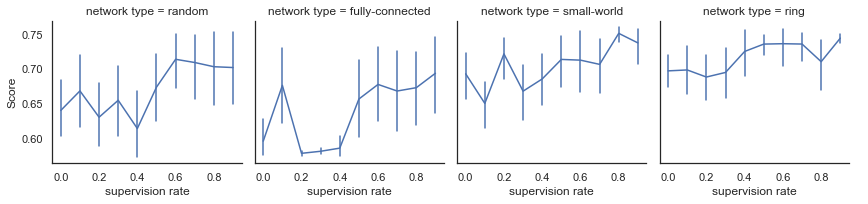

In [56]:
sns.set(style="white")
ax = sns.FacetGrid(df_7, col="network type")
ax.map(sns.lineplot,"supervision rate", "Score", 
                  err_style="bars")
ax.add_legend()

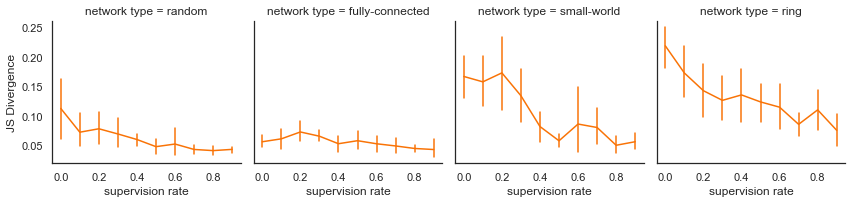

In [79]:
sns.set(style="white")
ax = sns.FacetGrid(df_7, col="network type")
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars", color=sns.xkcd_rgb["orange"], label = "between-agent meaning", legend=False)
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence')
#ax.add_legend()

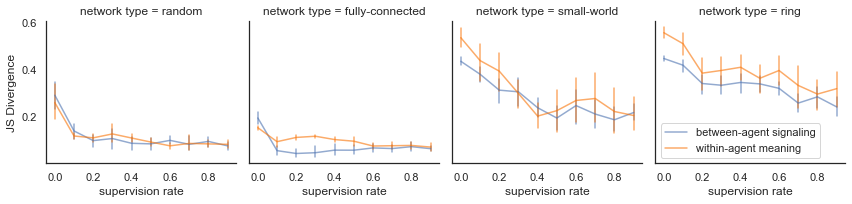

In [80]:
sns.set(style="white")
ax = sns.FacetGrid(df_7, col="network type")
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars", alpha=0.6, label = "between-agent signaling")
ax.map(sns.lineplot,"supervision rate", "meaning divergence", 
                  err_style="bars", alpha=0.6, color=sns.xkcd_rgb["orange"], label = "within-agent meaning")
#ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
#                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["red"], label = "shared meaning")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence')
plt.legend()

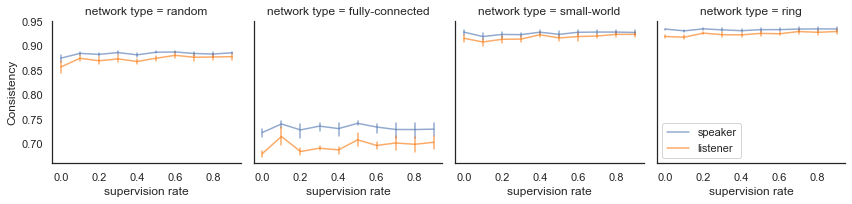

In [68]:
sns.set(style="white")
ax = sns.FacetGrid(df_7, col="network type")
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha=0.6, label = "speaker")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", alpha=0.6, color=sns.xkcd_rgb["orange"], label = "listener")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

#ax.add_legend()

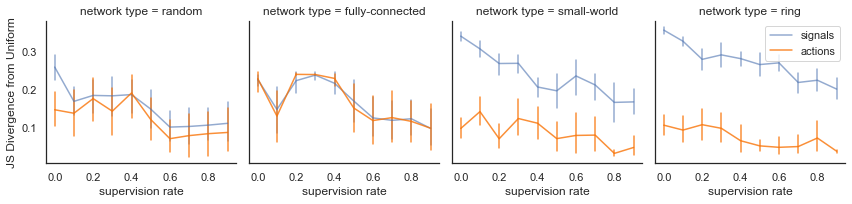

In [67]:
sns.set(style="white")
ax = sns.FacetGrid(df_7, col="network type")
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars", alpha=0.6, label = "signals")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars",  color=sns.xkcd_rgb["orange"], alpha=0.8, label = "actions")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence from Uniform')
plt.legend()


# Networks ER degrees

In [34]:
cond_list_8 = [[],[]]

degrees = [20, 30, 40, 50, 60, 70, 80, 90]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 5

for superv in supervision:
    for deg in degrees:
        for j in range(samples):
            cond_list_8[0].append(superv)
            cond_list_8[1].append(deg)

In [35]:
cond_list_8[0].pop(163)
cond_list_8[1].pop(163)

cond_list_8[0].pop(124)
cond_list_8[1].pop(124)



20

In [36]:
dirs = os.listdir("lang_games_net_structures_er_degrees/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game38.pkl',
 'game39.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game50.pkl',
 'game51.pkl',
 'game52.pkl',
 'game53.pkl',
 'game54.pkl',
 'game55.pkl',
 'game56.pkl',
 'game57.pkl',
 'game58.pkl',
 'game59.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'gam

In [38]:
games_8 = []
for file in dirs:
    with open("lang_games_net_structures_er_degrees/{}".format(file), "rb") as f:
        g = pickle.load(f)
        games_8.append(g)
        # for each game, the supervision condition is games[i][-1][0], the beta is games[i][-1][1]
        # returns [talks, acts, scores, samples, conditions] 
        # other parameters: play_many_games_semisupervised(n, 60000, 0, 0.0001, 4, 0, 10, 10, 0.3, supervision_rate)

In [39]:
mean_scores_8 = []
for i in range(len(cond_list_8[0])):
    means = []
    for n in range(10): # for each agent in the game
        means.append(np.mean(games_8[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_8.append(avg)

Calculating 

1) speaker and listener consistencies

2) action and talk KL-Divergence from Uniform distribution

3) divergence of agents' talk distributions

4) divergence of I-talk actions and others-talk actions

5) divergence of meanings for all symbols

In [40]:
n_agents = [10]*398
#sc_list7, lc_list7 = sl_consistencies(games_7, n_agents, 2000, False)
ac_div8, talk_div8 = action_talk_js_uniform(games_8, n_agents, 2000)
td8 = talk_divergence(games_8, n_agents, 2000)

In [41]:
sc_list8, lc_list8 = sl_consistencies(games_8, n_agents, 2000, False)

In [42]:
games_8_copy = copy.deepcopy(games_8)
div_list_8 = meaning_asymmetry(games_8_copy, n_agents, 2000, False, 120000)
games_8_copy = copy.deepcopy(games_8)
mean_map_8 = meaning_mapping(games_8_copy, n_agents, 2000, False, 120000)

In [48]:
data_8 = {"supervision rate": cond_list_8[0], "average degree": np.array(cond_list_8[1])/10, "score": mean_scores_8, 
         "speaker consistency": sc_list8, "listener consistency": lc_list8, 
         "action divergence from uniform": ac_div8, "talking divergence from uniform": talk_div8,
         "talking divergence": td8, "meaning divergence": div_list_8, "meaning mapping": mean_map_8}

In [49]:
df_8 = pd.DataFrame(data_8) 
df_8

supervision rate  average degree     score  speaker consistency  \
0                 0.0             2.0  0.742418             0.885350   
1                 0.0             2.0  0.588978             0.867355   
2                 0.0             2.0  0.725228             0.853401   
3                 0.0             2.0  0.627558             0.876403   
4                 0.0             2.0  0.688328             0.872766   
..                ...             ...       ...                  ...   
393               0.9             9.0  0.756626             0.735071   
394               0.9             9.0  0.751904             0.732953   
395               0.9             9.0  0.573712             0.689737   
396               0.9             9.0  0.761024             0.743860   
397               0.9             9.0  0.759698             0.751842   

     listener consistency  action divergence from uniform  \
0                0.872813                        0.054773   
1                0.845620                        0.212392   
2                0.847232                        0.061946   
3                0.849109                        0.121431   
4                0.860338                        0.077270   
..                    ...                             ...   
393              0.711409                        0.021774   
394              0.708261                        0.023104   
395              0.668279                        0.245752   
396              0.731637                        0.023591   
397              0.743240                        0.016506   

     talking divergence from uniform  talking divergence  meaning divergence  \
0                           0.184889            0.282623            0.170345   
1                           0.237368            0.230162            0.217740   
2                           0.241991            0.305225            0.236779   
3                           0.266748            0.314128            0.404734   
4                           0.233350            0.311222            0.181191   
..                               ...                 ...                 ...   
393                         0.053876            0.077622            0.051459   
394                         0.047000            0.066641            0.060680   
395                         0.146650            0.118173            0.075567   
396                         0.050146            0.070951            0.052522   
397                         0.042230            0.064286            0.053397   

     meaning mapping  
0           0.043041  
1           0.085984  
2           0.103605  
3           0.103899  
4           0.142994  
..               ...  
393         0.029383  
394         0.046518  
395         0.036993  
396         0.047595  
397         0.040773  

[398 rows x 10 columns]

In [57]:
df_8.to_pickle("./networks_er_dergees.pkl")

In [102]:
file = open('./networks_er_dergees.pkl', 'rb')

# dump information to that file
df_8 = pickle.load(file)

# close the file
file.close()

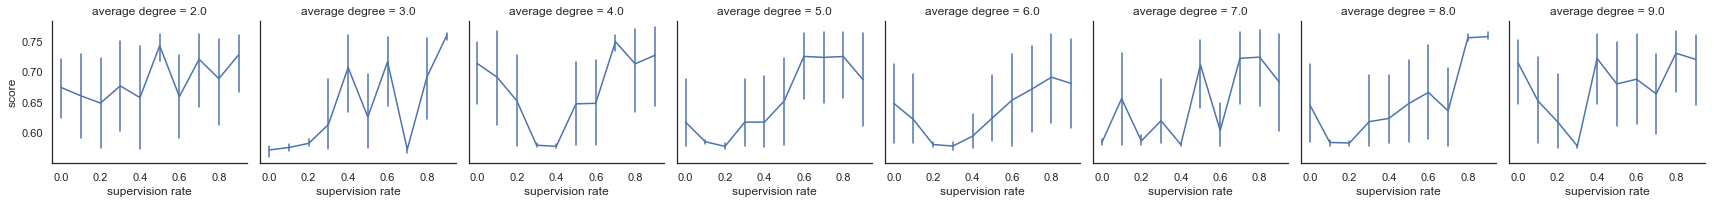

In [97]:
ax = sns.FacetGrid(df_8, col="average degree")
ax.map(sns.lineplot,"supervision rate", "score", 
                  err_style="bars")
ax.add_legend()

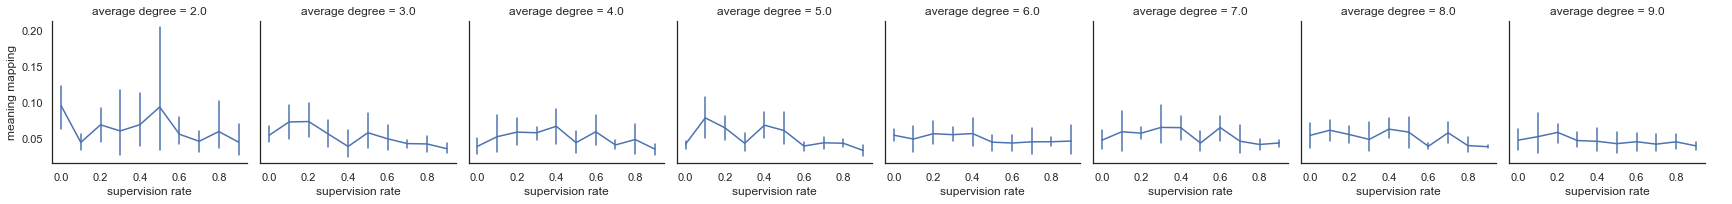

In [98]:
ax = sns.FacetGrid(df_8, col="average degree")
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars")
ax.add_legend()

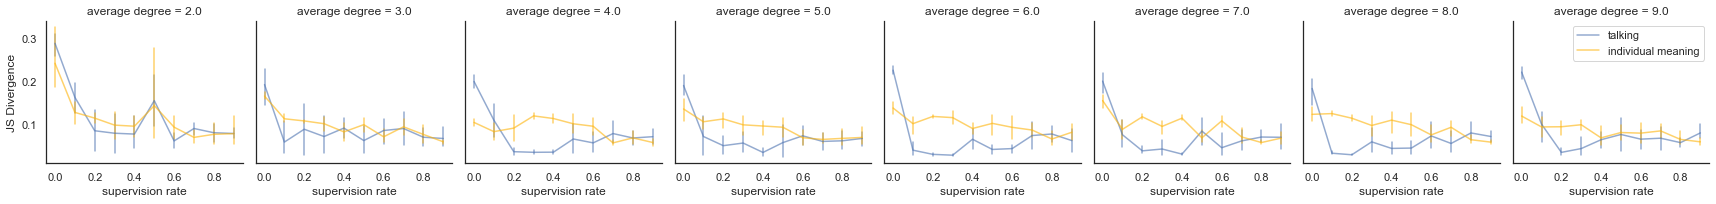

In [99]:
ax = sns.FacetGrid(df_8, col="average degree")
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars", alpha=0.6, label = "talking")
ax.map(sns.lineplot,"supervision rate", "meaning divergence", 
                  err_style="bars", alpha=0.6, color=sns.xkcd_rgb["amber"], label = "individual meaning")
#ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
#                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["red"], label = "shared meaning")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence')
plt.legend()

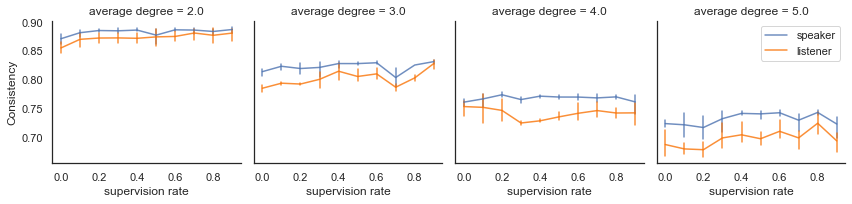

In [100]:
sns.set(style="white")
ax = sns.FacetGrid(df_8, col="average degree", col_order=[2.0, 3.0, 4.0, 5.0])
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha=0.8, label = "speaker")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["orange"], label = "listener")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

#ax.add_legend()

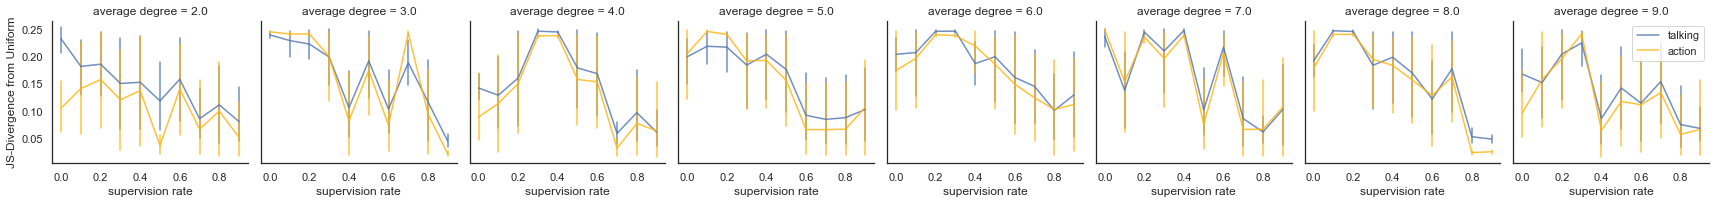

In [101]:
ax = sns.FacetGrid(df_8, col="average degree")
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars", alpha=0.8, label = "talking")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars",  color=sns.xkcd_rgb["amber"], alpha=0.8, label = "action")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS-Divergence from Uniform')
plt.legend()


# Global Local

In [19]:
cond_list_9 = [[],[]]

supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 5
gls = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for superv in supervision:
    for gl in gls:
        for j in range(samples):
            cond_list_9[0].append(superv)
            cond_list_9[1].append(gl)

In [20]:
dirs = os.listdir("lang_games_net_structures_global_local/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game50.pkl',
 'game51.pkl',
 'game52.pkl',
 'game53.pkl',
 'game54.pkl',
 'game55.pkl',
 'game56.pkl',
 'game57.pkl',
 'game58.pkl',
 'game59.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'game67.pkl',
 'game68.pkl',
 'gam

In [21]:
games_9 = []
for file in dirs:
    with open("lang_games_net_structures_global_local/{}".format(file), "rb") as f:
        g = pickle.load(f)
        games_9.append(g)
        # for each game, the supervision condition is games[i][-1][0], the beta is games[i][-1][1]
        # returns [talks, acts, scores, samples, conditions] 
        # other parameters: play_many_games_semisupervised(n, 60000, 0, 0.0001, 4, 0, 10, 10, 0.3, supervision_rate)

In [22]:
len(games_9)

496

In [23]:
cond_list_9[0].pop(38)
cond_list_9[1].pop(38)

cond_list_9[0].pop(38)
cond_list_9[1].pop(38)

cond_list_9[0].pop(350)
cond_list_9[1].pop(350)

cond_list_9[0].pop(353)
cond_list_9[1].pop(353)

0.1

In [24]:
mean_scores_9 = []
for i in range(len(cond_list_9[0])):
    means = []
    for n in range(10): # for each agent in the game
        means.append(np.mean(games_9[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_9.append(avg)

In [25]:
n_agents = [10]*496
#sc_list7, lc_list7 = sl_consistencies(games_7, n_agents, 2000, False)
ac_div9, talk_div9 = action_talk_js_uniform(games_9, n_agents, 2000)
td9 = talk_divergence(games_9, n_agents, 2000)

In [26]:
games_9_1 = games_9[:250]
games_9_2 = games_9[250:]
n_agents_1 = [10]*250
n_agents_2 = [10]*246

games_9_1_copy = copy.deepcopy(games_9_1)
div_list_9_1 = meaning_asymmetry(games_9_1_copy, n_agents_1, 2000, False, 120000)
games_9_2_copy = copy.deepcopy(games_9_2)
div_list_9_2 = meaning_asymmetry(games_9_2_copy, n_agents_2, 2000, False, 120000)


games_9_1_copy = copy.deepcopy(games_9_1)
mean_map_9_1 = meaning_mapping(games_9_1_copy, n_agents_1, 2000, False, 120000)
games_9_2_copy = copy.deepcopy(games_9_2)
mean_map_9_2 = meaning_mapping(games_9_2_copy, n_agents_2, 2000, False, 120000)

In [28]:
div_list_9=div_list_9_1+div_list_9_2
mean_map_9=mean_map_9_1+mean_map_9_2

In [27]:
sc_list9_1, lc_list9_1 = sl_consistencies(games_9_1, n_agents_1, 2000, False)
sc_list9_2, lc_list9_2 = sl_consistencies(games_9_2, n_agents_2, 2000, False)

In [29]:
sc_list9 = sc_list9_1+sc_list9_2
lc_list9 = lc_list9_1+lc_list9_2

In [46]:
data_9 = {"supervision rate": cond_list_9[0], "p global connection": cond_list_9[1], "score": mean_scores_9, 
         "speaker consistency": sc_list9, "listener consistency": lc_list9, 
         "action divergence from uniform": ac_div9, "talking divergence from uniform": talk_div9,
         "talking divergence": td9, "meaning divergence": div_list_9, "meaning mapping": mean_map_9}

In [47]:
df_9 = pd.DataFrame(data_9) 
df_9

supervision rate  p global connection     score  speaker consistency  \
0                 0.0                  0.0  0.700802             0.933316   
1                 0.0                  0.0  0.700428             0.933717   
2                 0.0                  0.0  0.569058             0.930192   
3                 0.0                  0.0  0.618516             0.932231   
4                 0.0                  0.0  0.637782             0.933445   
..                ...                  ...       ...                  ...   
491               0.9                  0.9  0.757512             0.897608   
492               0.9                  0.9  0.745716             0.900910   
493               0.9                  0.9  0.757412             0.889369   
494               0.9                  0.9  0.757216             0.892281   
495               0.9                  0.9  0.761308             0.891099   

     listener consistency  action divergence from uniform  \
0                0.917732                        0.085888   
1                0.913061                        0.096023   
2                0.914127                        0.238438   
3                0.924212                        0.198726   
4                0.919281                        0.159148   
..                    ...                             ...   
491              0.895587                        0.016225   
492              0.901022                        0.023188   
493              0.887283                        0.016701   
494              0.891964                        0.021612   
495              0.890329                        0.018698   

     talking divergence from uniform  talking divergence  meaning divergence  \
0                           0.353067            0.459066            0.540110   
1                           0.360073            0.475579            0.540579   
2                           0.367515            0.463016            0.488337   
3                           0.349513            0.411848            0.558774   
4                           0.355247            0.438690            0.605492   
..                               ...                 ...                 ...   
491                         0.040736            0.060136            0.055331   
492                         0.051116            0.070568            0.057394   
493                         0.042553            0.063591            0.058563   
494                         0.062303            0.092136            0.062291   
495                         0.039318            0.058055            0.047105   

     meaning mapping  
0           0.349071  
1           0.134678  
2           0.272858  
3           0.301638  
4           0.257179  
..               ...  
491         0.044059  
492         0.028479  
493         0.044390  
494         0.053242  
495         0.045884  

[496 rows x 10 columns]

In [82]:
df_9.to_pickle("./networks_global_local.pkl")

NameError: name 'df_9' is not defined

In [104]:
file = open('./networks_global_local.pkl', 'rb')

# dump information to that file
df_9 = pickle.load(file)

# close the file
file.close()

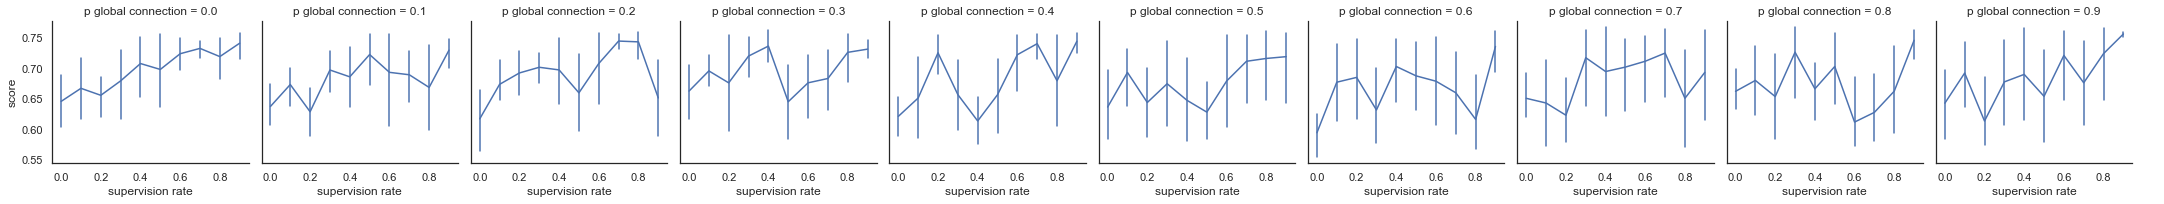

In [84]:
ax = sns.FacetGrid(df_9, col="p global connection")
ax.map(sns.lineplot,"supervision rate", "score", 
                  err_style="bars")
ax.add_legend()

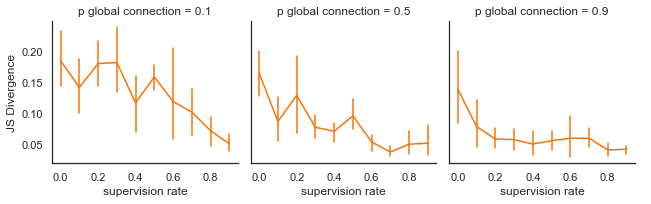

In [90]:
sns.set(style="white")
ax = sns.FacetGrid(df_9, col="p global connection", col_order=[0.1, 0.5, 0.9])
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars", color=sns.xkcd_rgb["orange"])
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence')
ax.add_legend()

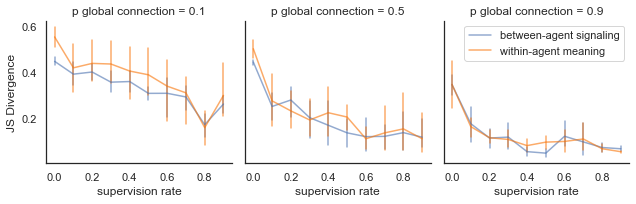

In [92]:
sns.set(style="white")
ax = sns.FacetGrid(df_9, col="p global connection", col_order=[0.1, 0.5, 0.9])
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars", alpha=0.6, label = "between-agent signaling")
ax.map(sns.lineplot,"supervision rate", "meaning divergence", 
                  err_style="bars", alpha=0.6, color=sns.xkcd_rgb["orange"], label = "within-agent meaning")
#ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
#                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["red"], label = "shared meaning")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence')
plt.legend()

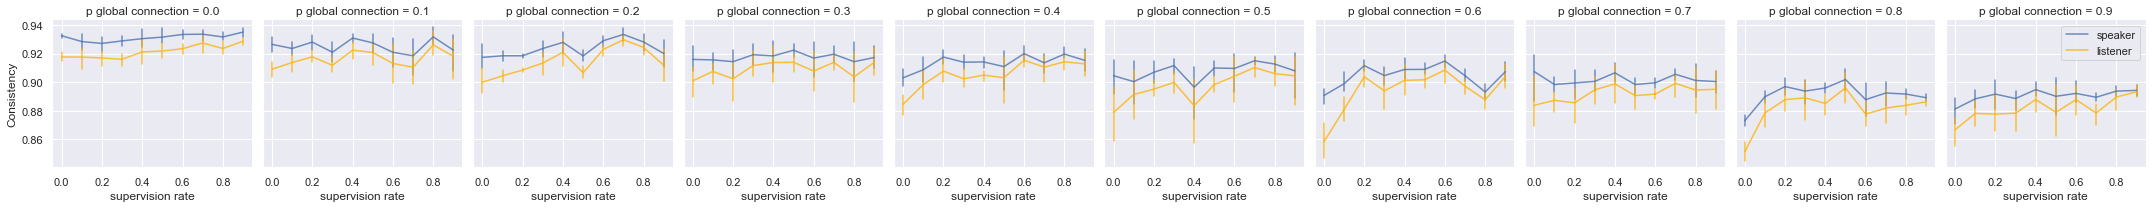

In [55]:
ax = sns.FacetGrid(df_9, col="p global connection")
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha=0.8, label = "speaker")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["amber"], label = "listener")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

#ax.add_legend()

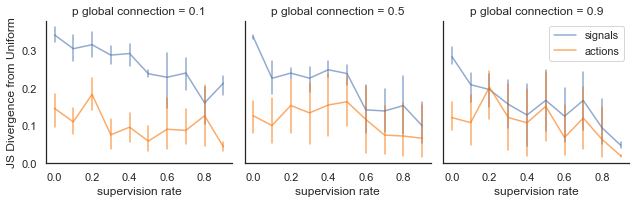

In [93]:
sns.set(style="white")
ax = sns.FacetGrid(df_9, col="p global connection", col_order=[0.1, 0.5, 0.9])
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars", alpha=0.6, label = "signals")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars",  color=sns.xkcd_rgb["orange"], alpha=0.6, label = "actions")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence from Uniform')
plt.legend()


# Network illustrations

In [71]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing import circular_layout
import pygraphviz
import statsmodels.api as sm
from scipy import stats


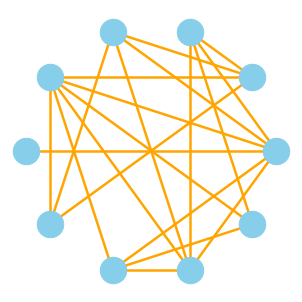

In [173]:
G = nx.gnm_random_graph(10, 20)
pos = circular_layout(G)
plt.figure(figsize=(4, 4))
nx.draw(G, pos, node_size=700, alpha=1, width=2.5, node_color="skyblue", edge_color="orange", with_labels=False)
plt.axis('equal')
plt.savefig("random.png")

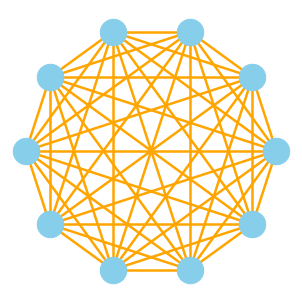

In [174]:
G = nx.complete_graph(10)
pos = circular_layout(G)
plt.figure(figsize=(4, 4))
nx.draw(G, pos, node_size=700, alpha=1, width=2.5, node_color="skyblue", edge_color="orange", with_labels=False)
plt.axis('equal')
plt.savefig("fully_connected.png")

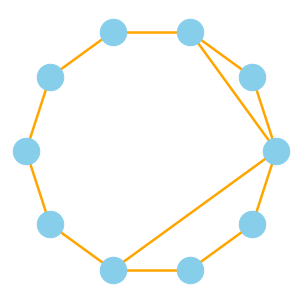

In [175]:
G = nx.newman_watts_strogatz_graph(10, 2, 0.2) 
pos = circular_layout(G)
plt.figure(figsize=(4, 4))
nx.draw(G, pos, node_size=700, width=2.5, alpha=1, node_color="skyblue", edge_color="orange", with_labels=False)
plt.axis('equal')
plt.savefig("small_world.png")

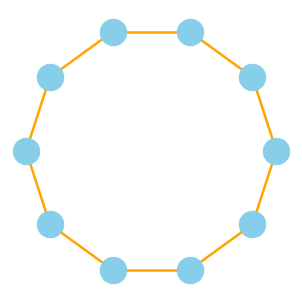

In [176]:
G = nx.connected_watts_strogatz_graph(10, 2, 0)
pos = circular_layout(G)
plt.figure(figsize=(4, 4))
nx.draw(G, pos, node_size=700, alpha=1, width = 2.5, node_color="skyblue", edge_color="orange", with_labels=False)
plt.axis('equal')
plt.savefig("ring.png")